In [41]:
import os
import sys
import numpy as np
import mapvbvd
from bart import bart
from matplotlib import pyplot as plt
import cfl
import PlotUtils

In [42]:
"""
Load Data 
"""
fullfile='/media/sf_ML_work/BART/rawData_exercise/meas_MID00573_FID48984_rest_stack.dat'

twixObj = mapvbvd.mapVBVD(fullfile)
sizeObj = len(twixObj)
twixObj[sizeObj-1].image.flagRemoveOS = False

data_hdr = twixObj[sizeObj-1].hdr

noSlices = int(data_hdr.Config.NSlc)
matrix = int(data_hdr.Config.ImageColumns)
nPhases = int(data_hdr.Config.NPhs)
accSpokes = int(data_hdr.Config.RadialViews)

del data_hdr
print(noSlices)
"12"
print(matrix) 
"192"
print(nPhases) 
"40"
print(accSpokes) 
"13"

"--------------------------------------"
"  data_hdr = twixObj[sizeObj-1].hdr "
"current size 384 26 13 1 12 1 40"

raw_data = np.squeeze(twixObj[sizeObj-1].image[:,:,:,:,:,:,:,:,:,:])
print("raw_data size = ", raw_data.shape)
" (384, 26, 13, 12, 40) "

"----------------------------------------------"

if noSlices == 1 :
    raw_data = np.permute(raw_data, [0, 1, 2, 4, 3])

nCoils = len(raw_data[1])
print(" nCoils = ", nCoils)

"""
% raw_data is currently stored in the format of:
%    matrix*2 (due to 2x OverSampling in readout directiom);
%    nCoils
%    accSpokes
%    noSlices
%    nPhases

% so in this case [384, 26, 13, 12, 40]

% reorder here just so that i can do gridding per 2D slice on each coil
% seperately
%data_image is now to be stored in the format of:
%    matrix*2 (due to 2x OverSampling in readout directiom);
%    accSpokes
%    nPhases
%    nCoils
%    noSlices

% so in this case [384, 13, 40, 26, 12]
"""
raw_data = np.transpose(raw_data, [0, 2, 4, 1, 3])
print("raw_data = ", raw_data.shape)

pymapVBVD version 0.4.2
Software version: VD


Scan 3/3, read all mdhs: 570MB [00:01, 261MB/s]

12
192
40
13


raw_data size =  (384, 26, 13, 12, 40)
 nCoils =  26
raw_data =  (384, 13, 40, 26, 12)


In [43]:
"now calculate the trajectory - get the radial angles from the raw data file"
"------------------------------------------------------"

uint16Angle0 = np.uint16(twixObj[sizeObj-1].image.iceParam[:,4])  #why are there 4 angles?
uint16Angle1 = np.uint16(twixObj[sizeObj-1].image.iceParam[:,5])
uint16Angle2 = np.uint16(twixObj[sizeObj-1].image.iceParam[:,6]) 
uint16Angle3 = np.uint16(twixObj[sizeObj-1].image.iceParam[:,7]) 

del twixObj
del sizeObj

tt1=np.stack((uint16Angle0, uint16Angle1, uint16Angle2, uint16Angle3)) #the 4 angles get stacked together
print("\n len(uint16Angle0) = ", len(uint16Angle0), " tt1= ", tt1.shape)

del uint16Angle0
del uint16Angle1
del uint16Angle2
del uint16Angle3

radialAngles = []
for i in range(accSpokes*nPhases) : #range 520
    tt4 = np.array(tt1[:, i], dtype=np.uint16)
    radialAngles.append(tt4.view(np.double)) #radial angles is what we make from the angles of the .dat file

del tt1
del tt4
del i #the temporary ones get deleted
""" 
  print("ii = ", i, " , ", tt4, " , ", combinedAngle[i]) 
"""

import math
" now create trajectory as used in the sequence, to match the above data "
    
npoints = accSpokes * (matrix*2) * nPhases; # (13x192x2x40) = 199680, why do we multiply this by 13?
dimensions  = 3

trajectory = np.zeros((dimensions, matrix*2, accSpokes, nPhases)) #(3,384,13,40) this is number of points
" weights    = np.zeros((matrix*2, accSpokes, nPhases))"

for phs in range(nPhases) : #40
    for lin in range(accSpokes) : #13 
        ang = radialAngles[phs*accSpokes + lin] #(0:39 x 13) + (0:12), goes up to 519

        cos_angle = math.cos(ang)
        sin_angle = math.sin(ang)
             
        for col in range(matrix*2) : #384
            kx = (col - matrix) /2  #(0:383 - 192) /2 because of the 2x oversampling
                
            trajectory[0, col, lin, phs]=(cos_angle*kx) #fill kx up with angles. (-192:192) 
            trajectory[1, col, lin, phs]=(sin_angle*kx) #(-192:192) 
            trajectory[2, col, lin, phs]=0.0 #kz = 0
            """            
            if kx == 0.0 :
                weights[col, lin, phs]= 0.25 
            else :
                weights[col, lin, phs]=  abs(kx) 
            """
del sin_angle
del cos_angle
del col 
del phs
del lin  
del kx       


 len(uint16Angle0) =  6240  tt1=  (4, 6240)


sliceData  (384, 13, 40, 26)
trajScale (3, 384, 520) dataCS_3124 (1, 384, 520, 26)
dataCS_perm tf.Tensor([    26 199680], shape=(2,), dtype=int32)
trajSc tf.Tensor([    26 199680      3], shape=(3,), dtype=int32) max traj 3.1415552722034468 min traj -3.141592653589793


2021-09-13 17:39:37.666407: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 613416960 exceeds 10% of free system memory.


average_gridded_data =  (26, 40, 192, 192)


AttributeError: 
        'EagerTensor' object has no attribute 'T'.
        If you are looking for numpy-related methods, please run the following:
        import tensorflow.python.ops.numpy_ops.np_config
        np_config.enable_numpy_behavior()

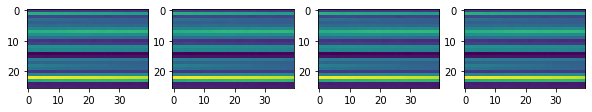

In [44]:
GRIDresult = np.zeros((matrix, matrix, nPhases, noSlices)) # (192,192,40,12)

noSlices = 1
for sl in range(noSlices) : #range 12
    sliceData = raw_data[:,:,:,:,sl] #[384, 13, 40, 26, 1] , why do we have the 13 in here? 

    print("sliceData ", sliceData.shape)
    dataCoilSensitivities = np.zeros((matrix*2, accSpokes*nPhases, 1, nCoils), dtype=complex) #(384,520,1,26) each of the k space points has its own sensitivity!
    trajScale = np.zeros((dimensions, matrix*2, accSpokes*nPhases)) #(3,384,520)

    " calculate coil sensitivities "
    " this stacks up the data over all time points, as we do a temporal average to get a fully sampled equivalent image to calculate the CS from"
    for ph in range(nPhases) : #40
        dataCoilSensitivities[:,ph*accSpokes:(ph+1)*accSpokes, 0, :] = np.squeeze(sliceData[:,:,ph,:]) #remove the [...,1] dimension from the end of sliceData. we are just reshaping here effectively
        trajScale[:,:,ph*accSpokes:(ph+1)*accSpokes] = trajectory[:,:,:, ph] #saving the trajectory of each slice as 3D matrix instead of 4D

    dataCS_3124 = np.transpose(dataCoilSensitivities, [2, 0, 1, 3]) #permute and save raw data as another variable before deletion
    del dataCoilSensitivities
    del ph

    "grid the data"
    "David: you need to chnage the following line to your gridder!!!!"
    print('trajScale',np.shape(trajScale),'dataCS_3124',np.shape(dataCS_3124))

    import tensorflow_nufft as tfft
    import tensorflow as tf
    
    #reshape the raw data
    dataCS_perm = tf.transpose(dataCS_3124, perm=[3,0,1,2])
    dataCS_perm =  tf.reshape(dataCS_perm , [nCoils, -1])
    print('dataCS_perm',tf.shape(dataCS_perm))

    #reshape the trajectory data
    trajSc= tf.transpose(trajScale, perm=[1,2,0])
    trajSc =  tf.reshape(trajSc , [-1 , 3])
    trajSc = tf.expand_dims(trajSc,axis=0)
    trajSc = tf.repeat(trajSc, repeats = 26, axis = 0)
    trajSc = (trajSc / 192) *2*np.pi
    print('trajSc',tf.shape(trajSc), 'max traj', np.max(trajSc), 'min traj', np.min(trajSc))

    average_gridded_data = tfft.nufft(dataCS_perm , trajSc, transform_type='type_1', fft_direction='backward', grid_shape=(40,192,192))

    # average_gridded_data = bart(1,"nufft -i -d"+str(matrix)+":"+str(matrix)+":1", trajScale, dataCS_3124) #The bart nufft

    print("average_gridded_data = ", average_gridded_data.shape)
    " size (192x192x1x26)"

    " this part is fine "
    fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(10,10))
    for cl in range(4) :
        ax[cl].imshow(abs(average_gridded_data[:,:,0, cl]))
    "  "
    del dataCS_3124

    ksp = bart(1, "fft -u 7", average_gridded_data)
    del average_gridded_data

    coil_sensitivities = bart(1, "caldir 20", ksp)
    " coil_sensivitoes = np.squeeze(coil_sensitivities) "
    del ksp
    " plot coil sensitivities"
    print("sl = ", sl, " , cS size = ", coil_sensitivities.shape)
    fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(10,10))
    for cl in range(5) :
        ax[cl].imshow(abs(coil_sensitivities[:,:,0,cl]))
    " "
    
    " ---------------------------------------------- "
    "now grid the data"

    " slice data is currently [matrix*2, accSpokes, nCoils, nPhases] "
    for ph in range(2) :
        "nPhases) :"

        dataAll = np.zeros((matrix*2, accSpokes, 1, nCoils),dtype=complex)
        trajAll = np.zeros((dimensions, matrix*2, accSpokes))

        dataAll[:,:,0,:] = np.squeeze(sliceData[:,:,ph,:])
        trajAll[:,:,:] = trajectory[:,:,:, ph]

        dataAll_3124 = np.transpose(dataAll, [2, 0, 1, 3]) 
        del dataAll

        "grid the data"
        "David: you need to chnage the following line to your gridder!!!!"
        gridded_data = bart (1,"nufft -i -d"+str(matrix)+":"+str(matrix)+":1", trajAll, dataAll_3124)
        print("gridded_data = ", gridded_data.shape)
        " size (192x192x1x26)"
        del dataAll_3124
        del trajAll

        gridded_data2=np.squeeze(np.transpose(gridded_data, [0, 1, 3, 2]))

        print("ph = ", ph  )
        fig, ax = plt.subplots(nrows=2, figsize=(6,10))
        ax[0].imshow(np.squeeze(abs(gridded_data2[:,:,20])), vmin=0, vmax =0.0001)

        """   
        print("gridded_data2 = ", gridded_data2.shape)
        print("coil_sensitivities = ", coil_sensitivities.shape)
        weightedData = abs(np.multiply(gridded_data2, np.conjugate(np.squeeze(coil_sensitivities))))
        print("weigghtedData = ", weightedData.shape)
     
        tempData = np.sum(weightedData, axis=2) 
        print("tempData = ", tempData.shape)
      
        GRIDresult[:,:,ph,sl] = abs(tempData)
        """  
    del ph  
    """
    print("sl = ", sl  )
    fig, ax = plt.subplots(nrows=5, figsize=(6,10))
    for ph in range(5) :
        ax[ph].imshow(np.squeeze(abs(GRIDresult[:,:,ph,sl])), vmin=0, vmax =0.001)
    " ---------------------------------------------- "
    """
    del coil_sensitivities
    
del dimensions
del radialAngles